In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:

# ---------- Data generating process ----------

def generate_batch(n, scam_share=0.1, n_features=6, random_state=None):
    rng = np.random.default_rng(random_state)
    y = rng.binomial(1, scam_share, size=n)

    # informative features
    f0 = rng.normal(loc=np.where(y==1, 2.0, 0.0), scale=1.0)  # strong shift
    f1 = rng.normal(loc=np.where(y==1, 1.0, -0.5), scale=1.0) # weaker shift

    # some non-linear-ish signal
    base = f0 + 0.5*f1
    f2 = np.tanh(base) + rng.normal(scale=0.5, size=n)

    # noise features
    n_noise = max(0, n_features - 3)
    noise = rng.normal(size=(n, n_noise)) if n_noise > 0 else np.empty((n, 0))

    X = np.column_stack([f0, f1, f2, noise])
    return X, y

# ---------- Audit policy (selection bias) ----------

def audit_probabilities(scores, alpha=3.0, base_rate=0.2):
    """
    scores: model-predicted P(y=1) in [0,1]
    alpha>0: focus audits on high-risk cases
    alpha<0: focus audits on low-risk cases
    base_rate: overall expected audit fraction
    """
    if base_rate >= 1.0:
        return np.ones_like(scores)
    centered = scores - 0.5
    weights = np.exp(alpha * centered)
    weights /= weights.mean()  # normalise to mean 1
    p_audit = np.clip(base_rate * weights, 0.0, 1.0)
    return p_audit

# ---------- significance testing for probality shifts ----------
def test_score_shift(scores_ref, scores_new):
    """
    Perform a two-sample Kolmogorov-Smirnov test to detect distributional shifts
    between reference scores and new scores.
    """
    from scipy.stats import ks_2samp
    stat, p_value = ks_2samp(scores_ref, scores_new)
    return stat, p_value    

# use base results to extract CI
def compute_ci_thresholds(metric_array, ci=0.95):
    lower_bound = np.percentile(metric_array, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(metric_array, (1 + ci) / 2 * 100)
    return np.abs(upper_bound-lower_bound) / 2

# helper function to plot true and seen with CI bands
def plot_with_ci(steps, true_metric, seen_metric, ci_threshold, metric_name):
    plt.figure()
    plt.plot(steps, true_metric, label=f"True {metric_name}", color='blue')
    plt.fill_between(steps, true_metric - ci_threshold, true_metric + ci_threshold, color='blue', alpha=0.2)
    plt.plot(steps, seen_metric, label=f"Seen {metric_name}", color='orange', linestyle='--')
    plt.xlabel("Iteration")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over feedback iterations with CI")
    plt.legend()
    plt.show()

    
# ---------- Simulation loop ----------

def run_feedback_sim(
    n_steps=30,
    batch_size=5000,
    scam_share=0.1,
    alpha=3.0,
    base_audit_rate=0.2,
    n_features=6,
    random_state=0,
    N_window=2000,
    threshold=0.5,
):
    
    rng = np.random.default_rng(random_state)

    # initial training data: fully labeled (no feedback yet)
    X_full, y_full = generate_batch(batch_size, scam_share=scam_share, n_features=n_features)

    # corresponding model score (initially same as truth)
    y_seen = y_full.copy()

    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=5,
        n_jobs=-1
    )

    # to store trajectories
    real_auc, seen_auc = [], []
    real_f1, seen_f1 = [], []
    real_acc, seen_acc = [], []
    feature_importances = []
    score_distributions = []
    p_values_shift = []

    for t in range(n_steps):

        # take last N_window samples as train/test set
        X = X_full[-N_window:]
        y = y_seen[-N_window:]

        # take ground truth labels
        y_true = y_full[-N_window:]

        # split test/train and keep ground truth for test
        X_train, X_test, y_train, y_test, _, y_true_test = train_test_split(
            X, y, y_true, test_size=0.2)


        # --- train on current contaminated training dataset ---

        model.fit(X_train, y_train)
        proba_test = model.predict_proba(X_test)[:, 1]


        # --- evaluate on full-truth test set (REAL performance) ---

        y_test_pred = (proba_test >= threshold).astype(int)
        real_auc.append(roc_auc_score(y_true_test, proba_test))
        real_f1.append(f1_score(y_true_test, y_test_pred))
        real_acc.append(accuracy_score(y_true_test, y_test_pred))


        # --- evaluate on data with pseudo-labels (SEEN performance) ---   

        p_audit_val = audit_probabilities(proba_test, alpha=alpha, base_rate=base_audit_rate)
        audits_val = rng.binomial(1, p_audit_val)
        # audited positions get true labels; non-audited keep pseudo labels
        pseudo_val_labels = np.where(audits_val == 1, y_true_test, y_test)

        seen_auc.append(roc_auc_score(pseudo_val_labels, proba_test))
        seen_f1.append(f1_score(pseudo_val_labels, y_test_pred))
        seen_acc.append(accuracy_score(pseudo_val_labels, y_test_pred))        

        # store score distribution on test
        score_distributions.append(proba_test.copy())

        # if initial step, store initial score distribution for shift testing
        if t == 0:
            initial_scores = proba_test.copy()
        
        # store score shift test result
        stat, p_value = test_score_shift(initial_scores, proba_test)
        p_values_shift.append(p_value)

        # track feature importances
        feature_importances.append(model.feature_importances_.copy())


        # --- generate new data and contaminate ---

        X_new, y_new_true = generate_batch(batch_size, scam_share=scam_share, n_features=n_features)
        proba_new = model.predict_proba(X_new)[:, 1]    
        p_audit_new = audit_probabilities(proba_new, alpha=alpha, base_rate=base_audit_rate)
        audits_new = rng.binomial(1, p_audit_new)   
        pseudo_val_labels = np.where(audits_new == 1, y_new_true, (proba_new >= threshold).astype(int))    


        # --- feedback step: add to training set ---

        # accumulate contaminated data
        X_full = np.vstack([X_full, X_new])
        y_seen = np.concatenate([y_seen, pseudo_val_labels])

        # accumulate true labels for evaluation
        y_full = np.concatenate([y_full, y_new_true])   


    results = {
        "real_auc": np.array(real_auc),
        "seen_auc": np.array(seen_auc),
        "real_f1": np.array(real_f1),
        "seen_f1": np.array(seen_f1),
        "real_acc": np.array(real_acc),
        "seen_acc": np.array(seen_acc),
        "feature_importances": np.vstack(feature_importances),
        "score_distributions": score_distributions,
        "p_values_shift": np.array(p_values_shift)
    }
    return results



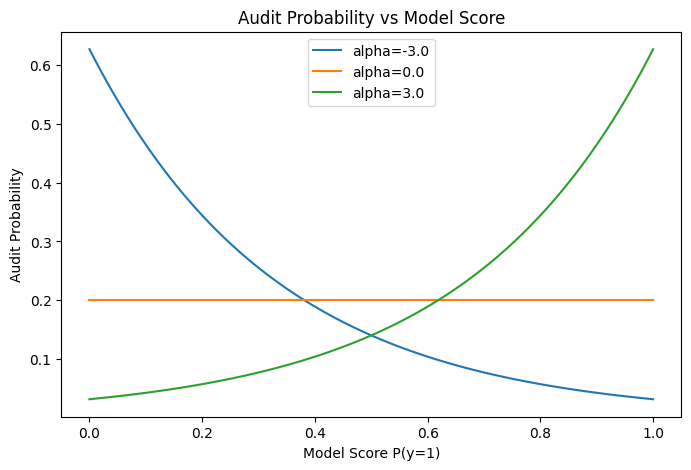

In [22]:
# display audit probability distribution for different alphas   
scores = np.linspace(0, 1, 100)
alphas = [-3.0, 0.0, 3.0]
base_rate = 0.2

plt.figure(figsize=(8, 5))
for alpha in alphas:
    p_audit = audit_probabilities(scores, alpha=alpha, base_rate=base_rate)
    plt.plot(scores, p_audit, label=f'alpha={alpha}')

plt.xlabel('Model Score P(y=1)')
plt.ylabel('Audit Probability')
plt.title('Audit Probability vs Model Score')
plt.legend()
#plt.grid()
plt.show()

In [61]:
def plot_all(results, ci_real_auc, ci_real_f1,ci_real_acc):

    steps = np.arange(len(results["real_auc"]))

    plot_with_ci(steps, results["real_auc"], results["seen_auc"], ci_real_auc, "AUC")
    plot_with_ci(steps, results["real_f1"], results["seen_f1"], ci_real_f1, "F1")
    plot_with_ci(steps, results["real_acc"], results["seen_acc"], ci_real_acc, "Accuracy")

    plt.figure()
    plt.plot(steps, results["feature_importances"])
    plt.xlabel("Iteration")
    plt.ylabel("Feature importance")
    plt.title("RF feature importances over time")
    plt.show()

    # Example: plot score distributions at a few iterations
    for t in [0, 5, 10, 20, 29]:
        plt.hist(results["score_distributions"][t], bins=20, alpha=0.3, density=True, label=f"t={t}")
    plt.xlabel("Predicted P(scam)")
    plt.ylabel("Density")
    plt.title("Score distributions on test over time")
    plt.legend()
    plt.show()

    # plot p-values from score shift test
    plt.figure()
    plt.plot(steps, results["p_values_shift"], marker='o')
    plt.axhline(0.05, color='red', linestyle='--', label='Significance level (0.05)')
    plt.xlabel("Iteration")
    plt.ylabel("p-value from KS test")
    plt.title("p-values from score distribution shift test over time")
    plt.legend()
    plt.show()

In [ ]:

# simulate without feedback bias (alpha=0 and audit rate=1)
results_base = run_feedback_sim(
    n_steps=30,
    scam_share=0.3,
    alpha=0.,
    base_audit_rate=1.,
    n_features=6
)

ci_real_auc = compute_ci_thresholds(results_base["real_auc"])
ci_real_f1 = compute_ci_thresholds(results_base["real_f1"])
ci_real_acc = compute_ci_thresholds(results_base["real_acc"])

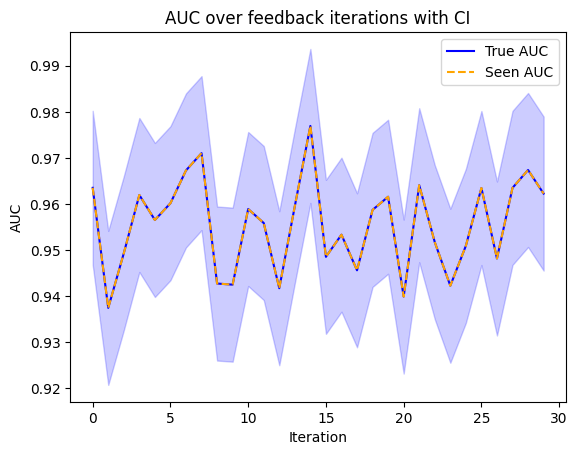

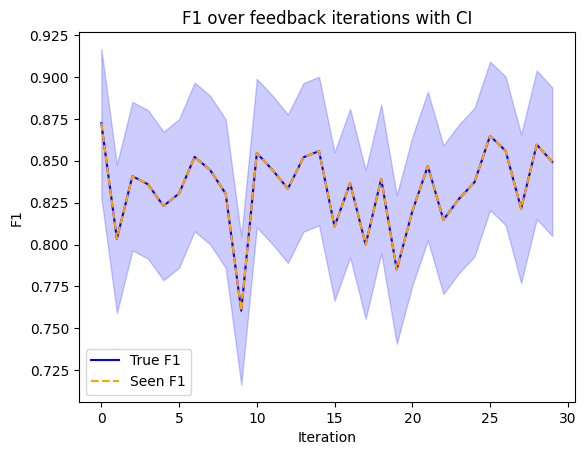

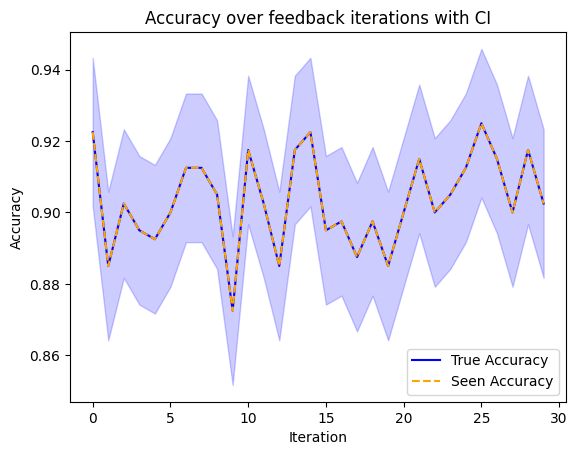

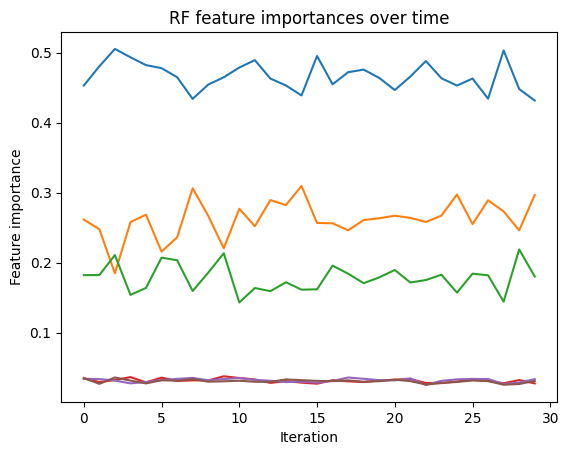

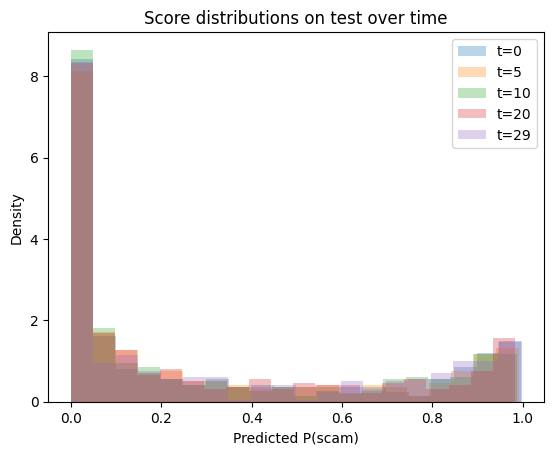

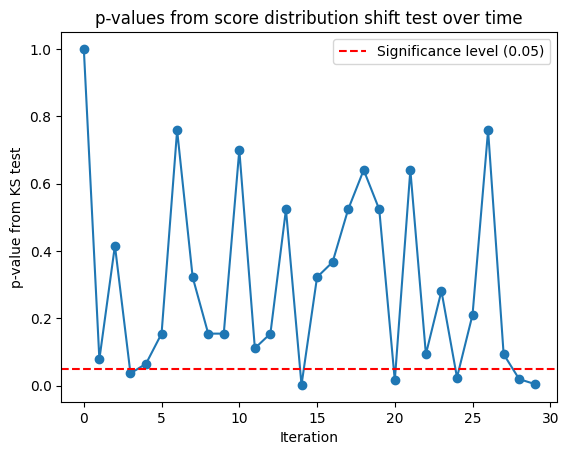

In [ ]:
plot_all(results_base, ci_real_auc, ci_real_f1,ci_real_acc)

In [45]:
results = run_feedback_sim(
    n_steps=30,
    scam_share=0.3,
    alpha=3.0,
    base_audit_rate=0.5,
    n_features=6
)

steps = np.arange(len(results["real_auc"]))

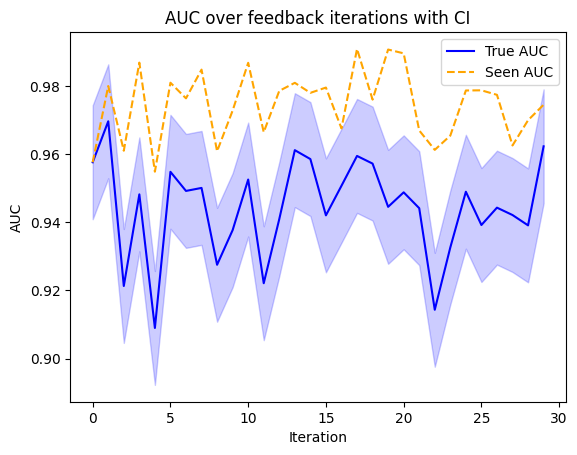

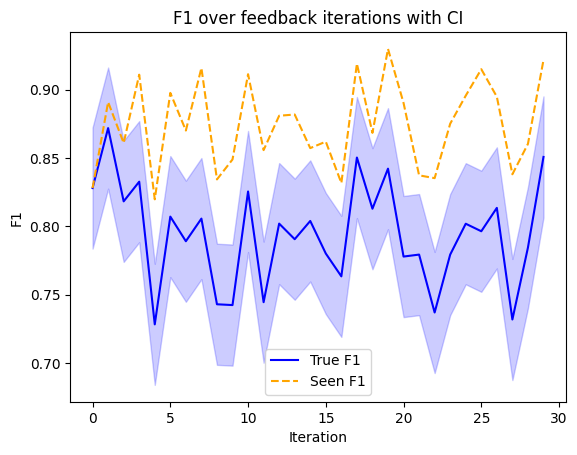

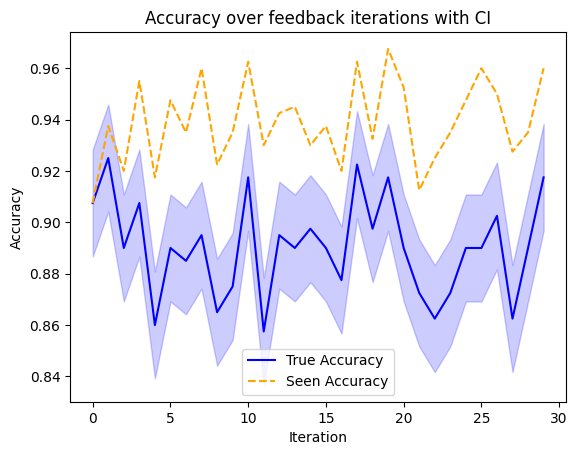

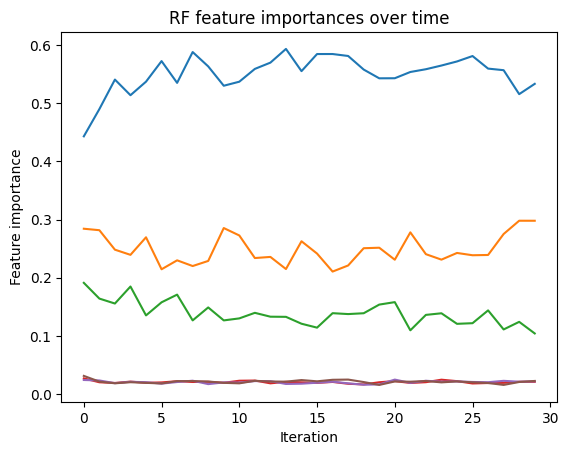

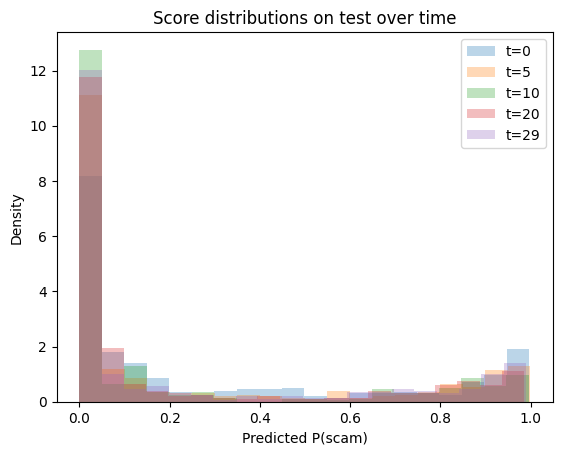

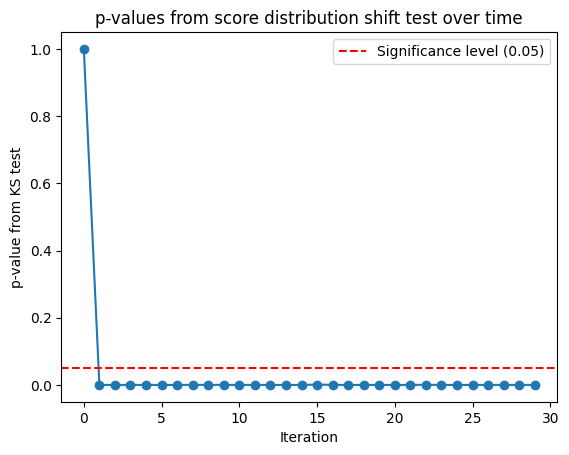

In [63]:
plot_all(results, ci_real_auc, ci_real_f1,ci_real_acc)
